# Gem strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/gem.csv")
print(df.head())

         Date  BND  EUM  IAU        SPY        QQQ        TLT
0  2002-08-08  0.0  0.0  0.0  90.949997  23.570000  83.699997
1  2002-08-09  0.0  0.0  0.0  91.290001  23.330000  84.879997
2  2002-08-12  0.0  0.0  0.0  90.620003  23.400000  85.400002
3  2002-08-13  0.0  0.0  0.0  88.970001  22.600000  86.449997
4  2002-08-14  0.0  0.0  0.0  92.220001  24.040001  86.779999


In [3]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365  # in days
STARTING_CACHE = 1000

# Remove weekends form the simulation
REBALANCE_PERIOD = int(REBALANCE_PERIOD / 7 * 5)
COMPARISON_TIME_WINDOW = int(COMPARISON_TIME_WINDOW / 7 * 5)

## Buy and hold

In [4]:
BUY_AND_HOLD = "SPY"

cache = STARTING_CACHE
values = []
days = []
amount = 0

amount = cache / df.iloc[COMPARISON_TIME_WINDOW][BUY_AND_HOLD]
cache = 0

for i in range(
        COMPARISON_TIME_WINDOW, len(df.index) - COMPARISON_TIME_WINDOW, REBALANCE_PERIOD
):
    values.append(amount * df.iloc[i][BUY_AND_HOLD])
    days.append(df.iloc[i]["Date"])

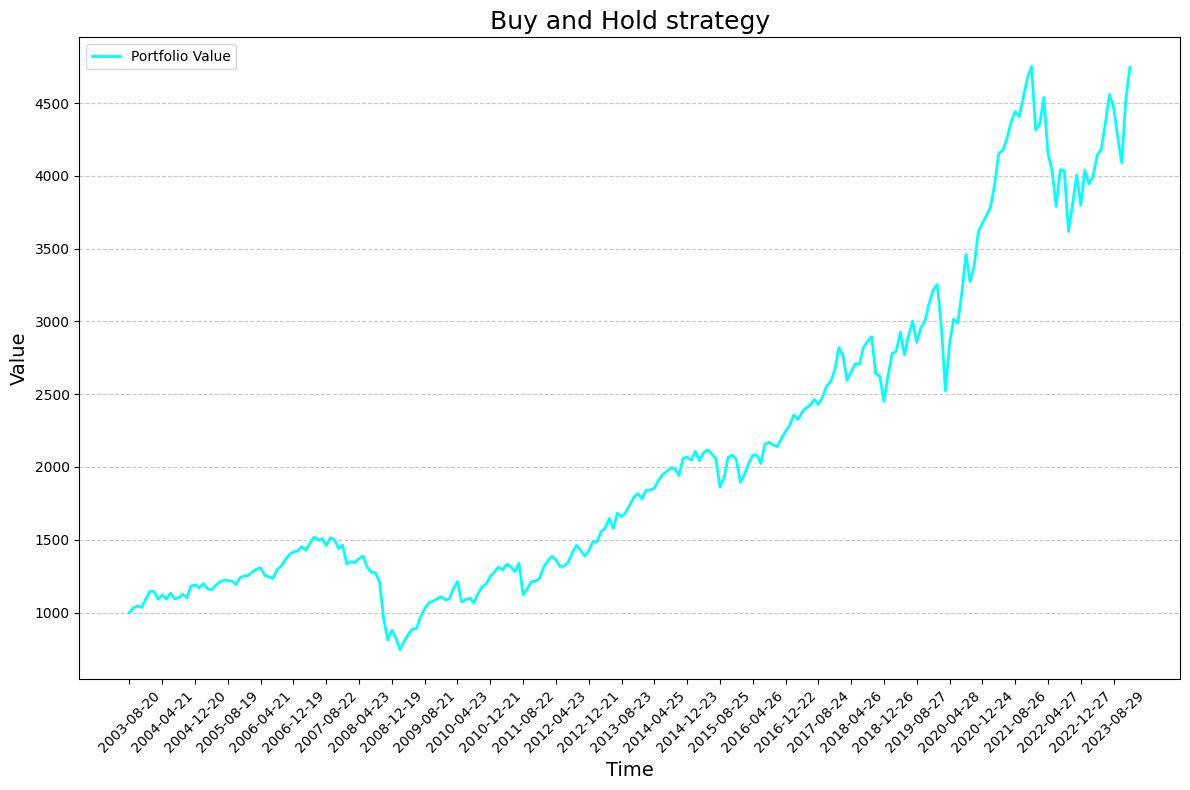

In [5]:
def plot(plot_days, plot_values, title):
    plt.figure(figsize=(12, 8))
    plt.plot(plot_days, plot_values, label="Portfolio Value", color="aqua", linewidth=2)
    plt.title(title, fontsize=18)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.xticks(plot_days[::8], rotation=45)
    plt.legend(loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


plot(days, values, "Buy and Hold strategy")

## GEM

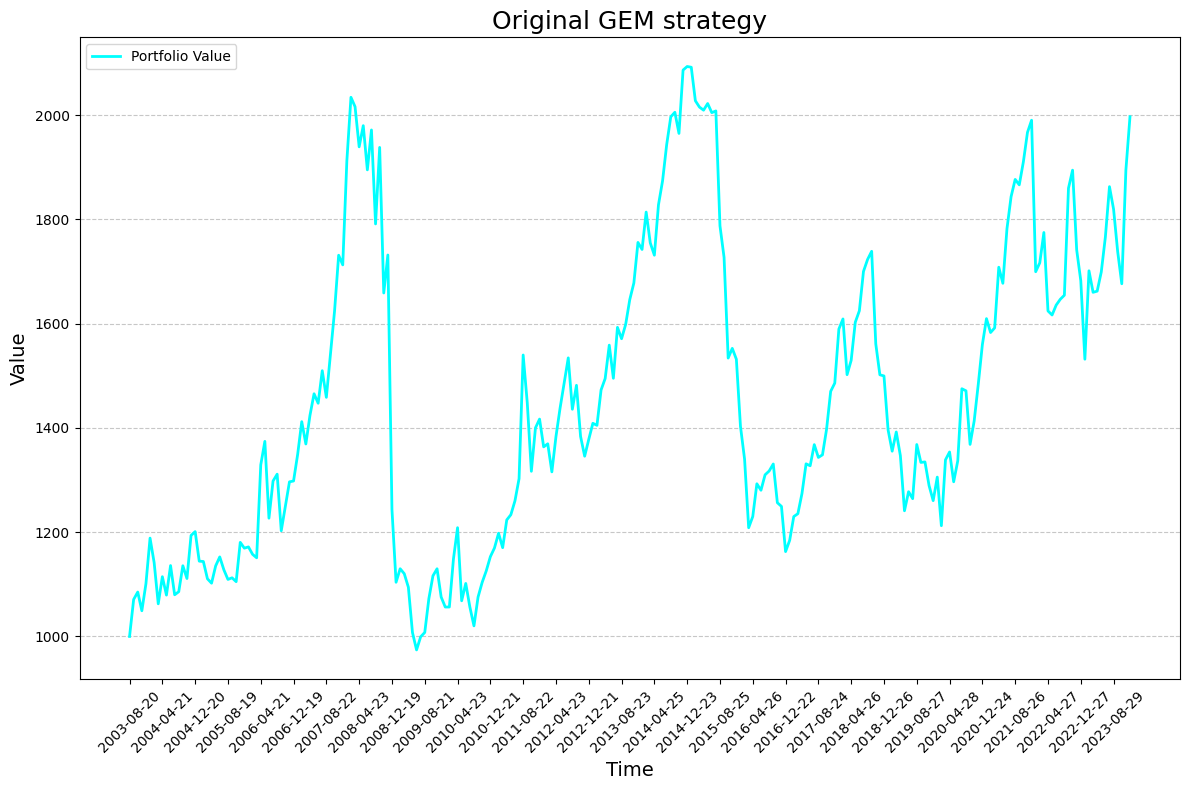

In [6]:
def gem_sim():
    cache = STARTING_CACHE
    values = []
    days = []
    asset = (
        ""  # it has no price at the beginning so will be switched as soon as possible
    )
    amount = 0
    tickets = ["BND", "EUM", "IAU", "SPY", "QQQ", "TLT"]

    for i in range(
            COMPARISON_TIME_WINDOW, len(df.index) - COMPARISON_TIME_WINDOW, REBALANCE_PERIOD
    ):
        value_change = {}
        for ticket in tickets:
            start_value = df.iloc[i - COMPARISON_TIME_WINDOW][ticket]
            end_value = df.iloc[i][ticket]

            if start_value == 0:
                value_change[ticket] = -1
            else:
                value_change[ticket] = end_value / start_value - 1
        best_performer = max(value_change, key=value_change.get)

        if best_performer != asset:
            if asset == "":
                asset = best_performer
            else:
                cache = df.iloc[i][asset] * amount
            amount = cache / df.iloc[i][best_performer]
            asset = best_performer
            cache = 0

        values.append(amount * df.iloc[i][asset])
        days.append(df.iloc[i]["Date"])
    return values, days


values, days = gem_sim()
plot(days, values, "Original GEM strategy")

## GEP sim 2

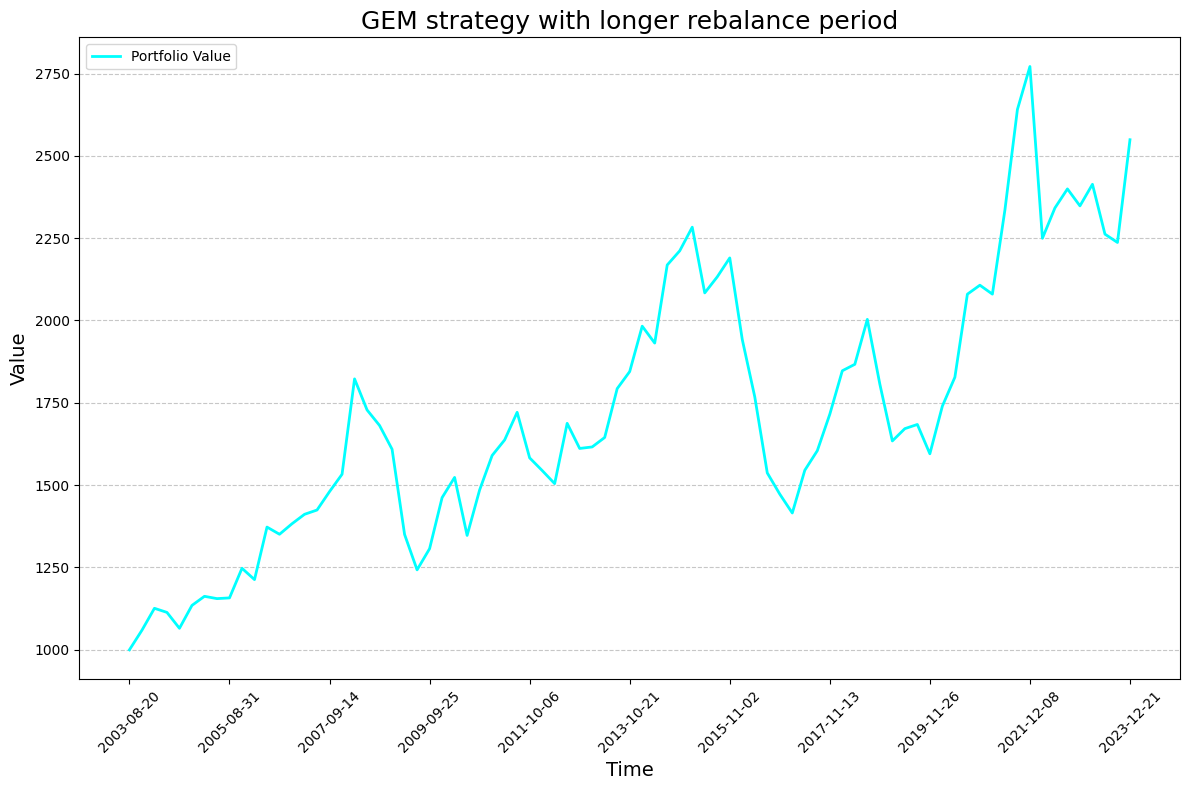

In [7]:
REBALANCE_PERIOD = 30 * 3  # in days
COMPARISON_TIME_WINDOW = 365  # in days

# Remove weekends form the simulation
REBALANCE_PERIOD = int(REBALANCE_PERIOD / 7 * 5)
COMPARISON_TIME_WINDOW = int(COMPARISON_TIME_WINDOW / 7 * 5)

gem_values_long_period, gem_days_long_period = gem_sim()
plot(
    gem_days_long_period,
    gem_values_long_period,
    "GEM strategy with longer rebalance period",
)

## GEP sim 3

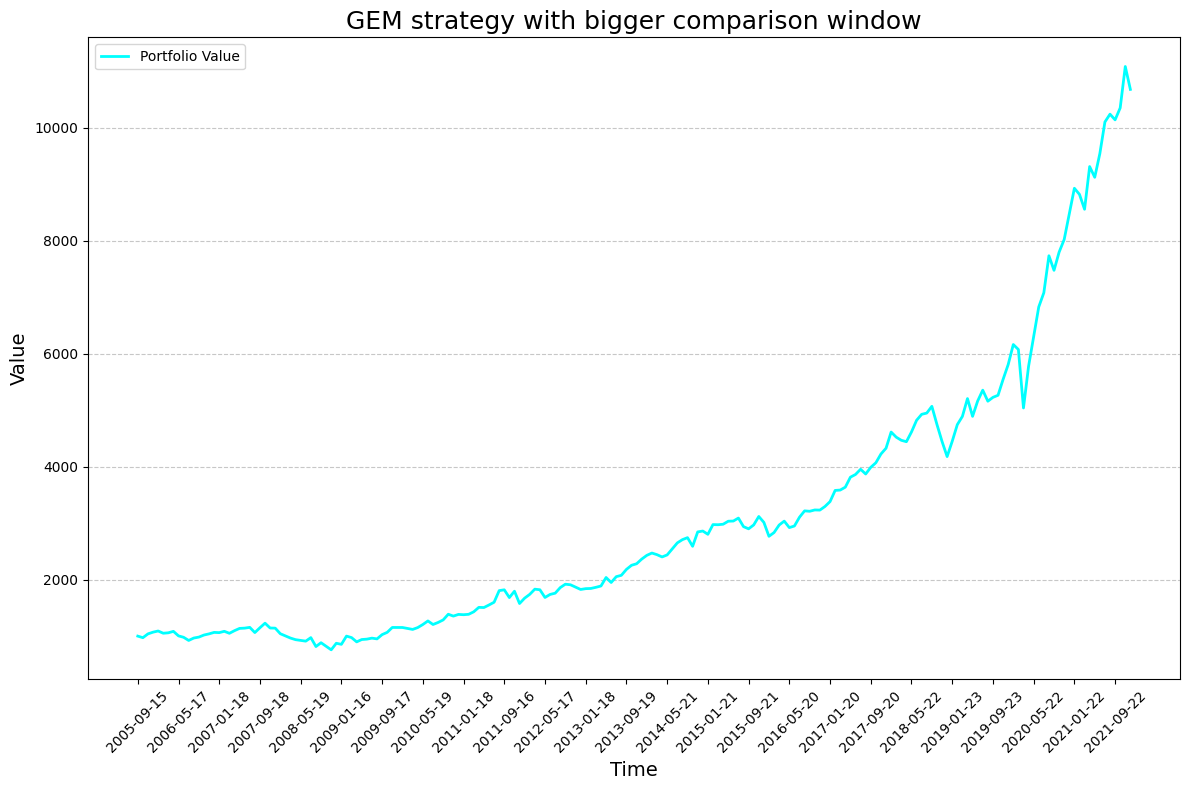

In [8]:
REBALANCE_PERIOD = 30  # in days
COMPARISON_TIME_WINDOW = 365 * 3  # in days

# Remove weekends form the simulation
REBALANCE_PERIOD = int(REBALANCE_PERIOD / 7 * 5)
COMPARISON_TIME_WINDOW = int(COMPARISON_TIME_WINDOW / 7 * 5)

gem_values_bigger_window, gem_days_bigger_window = gem_sim()
plot(
    gem_days_bigger_window,
    gem_values_bigger_window,
    "GEM strategy with bigger comparison window",
)